#Bài toán 2: dự đoán khả năng mở rộng bơ organic tại California

In [1]:
#Note: đối với bài toán time series, dữ liệu phải liên tục
#---> không loại outlier. Không xóa dòng.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do'

/content/gdrive/My Drive/LDS0_k271_HoangDucHuy/Project_01_price_prediction_and_time_series/Re_do


###Chuẩn bị data

In [3]:
#lấy data từ đầu, không lấy data đã qua xử lý

In [4]:
%%capture
!pip install fbprophet
!pip install pandas-profiling==2.7.1
!pip install pmdarima
!pip install xgboost

In [5]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from pmdarima import auto_arima 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [97]:
data = pd.read_csv('avocado.csv', index_col = 0)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [99]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


#Áp dụng các thuật toán time series để dự đoán giá bơ organic trong tương lại ở California

In [100]:
#sử dụng các thuật toán như ARIMA, Prophet, Holt-Winter

In [101]:
df = data[['Date', 'AveragePrice', 'type', 'region']]

In [102]:
#lọc lấy region = California và type =  organic
df = df[df['region'] == 'California']
df = df[df['type'] == 'organic']

In [103]:
df.head()

,Date,AveragePrice,type,region
0,2015-12-27,1.45,organic,California
1,2015-12-20,1.35,organic,California
2,2015-12-13,1.39,organic,California
3,2015-12-06,1.48,organic,California
4,2015-11-29,1.75,organic,California


In [104]:
#chuyển cột Date sang dạng datetime
df['Date']= pd.to_datetime(df['Date'])

In [105]:
#MS: Month Start, tính mean của các tháng theo month
df1 = df.resample('MS', on='Date').mean()

In [106]:
df1.head()

,AveragePrice
Date,
2015-01-01,1.2200
2015-02-01,1.3475
2015-03-01,1.3960
2015-04-01,1.5100
2015-05-01,1.4740


In [107]:
df1 = df1.rename_axis('Month').reset_index()
df1.head()

,Month,AveragePrice
0,2015-01-01,1.2200
1,2015-02-01,1.3475
2,2015-03-01,1.3960
3,2015-04-01,1.5100
4,2015-05-01,1.4740


In [108]:
#đổi tên cá cột
df1.columns = ['ds','y']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      39 non-null     datetime64[ns]
 1   y       39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 752.0 bytes


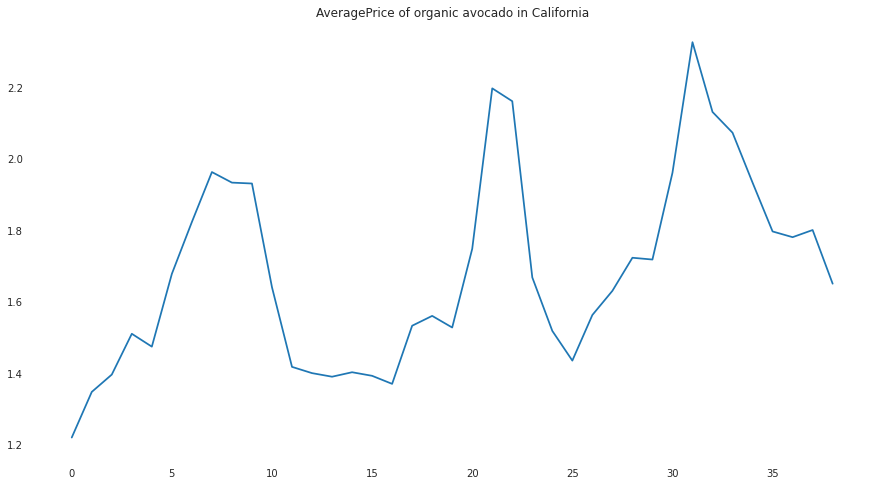

In [109]:
# Trực quan hóa giá trung bình qua các tháng
plt.figure(figsize=(15,8))
plt.plot(df1.y)
plt.title('AveragePrice of organic avocado in California')
plt.show()

Nhận xét: giá trung bình có xu hướng tăng qua các thời kỳ

In [ ]:
#chia dữ liệu train/ test

In [ ]:
#có 39 tháng --> 30 tháng cho train, 9 tháng cho test

In [112]:
#39 tháng cho train
train = df1.iloc[0:30]
train.tail()

,ds,y
25,2017-02-01,1.4350
26,2017-03-01,1.5625
27,2017-04-01,1.6300
28,2017-05-01,1.7225
29,2017-06-01,1.7175


In [113]:
#9 tháng cho test
test = df1.iloc[30:]
test.tail()

,ds,y
34,2017-11-01,1.9325
35,2017-12-01,1.7960
36,2018-01-01,1.7800
37,2018-02-01,1.8000
38,2018-03-01,1.6500


In [115]:
test.head()

,ds,y
30,2017-07-01,1.9600
31,2017-08-01,2.3250
32,2017-09-01,2.1300
33,2017-10-01,2.0720
34,2017-11-01,1.9325


###Bước 4&5: Modeling & Evaluation/ Analyze & Report

#Build model - Prophet

In [114]:
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(train) #fit train --> 30 tháng

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [116]:
#9 month in test and 12 month to preidct new value
#test bắt đầu từ 2017-07-01, kết thúc 2018-03-01
#predict thêm 1 năm ==> kết thúc 2019-03-01
#model sẽ predict thời gian từ 9 tháng của test cộng thêm 12 tháng mới
months = pd.date_range('2017-07-01','2019-03-01',freq='MS').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(months)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [117]:
#use model to make forcast
forecast = model.predict(future) 

In [119]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2017-07-01,1.902270
1,2017-08-01,1.924667
2,2017-09-01,2.056903
3,2017-10-01,2.344925
4,2017-11-01,2.213124


In [120]:
forecast[['ds', 'yhat']].tail()

,ds,yhat
16,2018-11-01,2.327422
17,2018-12-01,2.035509
18,2019-01-01,1.902338
19,2019-02-01,1.939626
20,2019-03-01,1.966178


#Evaluate

In [121]:
df1['y'].mean()

1.6847820512820515

In [122]:
test['y'].mean()

1.9383888888888887

In [ ]:
#tính toán MAE/RMSE giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred)

In [123]:
y_test = test['y'].values #giá trị thực (9 giá trị)
y_pred = forecast['yhat'].values[:9] #9 giá trị đầu tiên
mae_p = mean_absolute_error(y_test,y_pred)
print('MAE: %.3f' %mae_p)

MAE: 0.166


In [124]:
rmse_p = sqrt(mean_squared_error(y_test,y_pred))
print('RMSE: %.3f' %rmse_p)

RMSE: 0.204


Nhận xét:
- mean(test) ~ 1.94, mae ~ 0.17 --> mean(mae)/mean(test) ~ 8.7 %
- mean của toàn data (df1.y) ~ 1.68, mae ~ 0.17 --> mean(mae)/mean(toàn data) ~ 10 %
==> sai lệch nhỏ, có thể chấp nhận

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

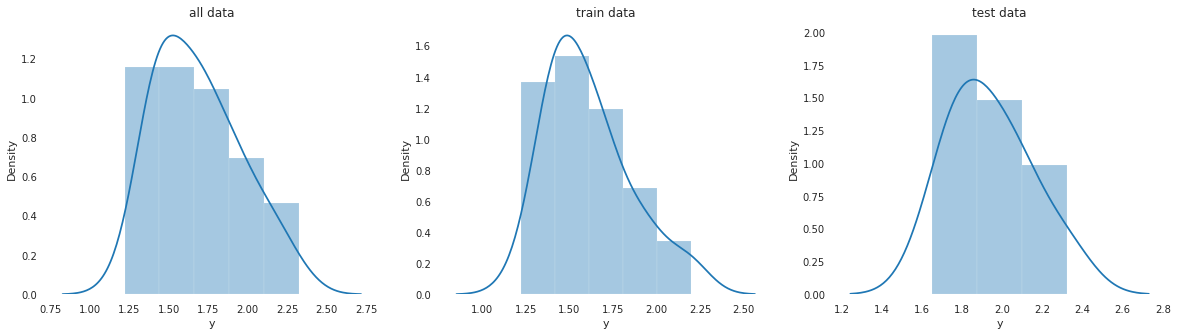

In [125]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(df1['y'])
plt.title('all data')
plt.subplot(1,3,2)
sns.distplot(train['y'])
plt.title('train data')
plt.subplot(1,3,3)
sns.distplot(test['y'])
plt.title('test data')
plt.show()

In [126]:
y_test 

array([1.96  , 2.325 , 2.13  , 2.072 , 1.9325, 1.796 , 1.78  , 1.8   ,
       1.65  ])

In [127]:
y_pred 

array([1.90226955, 1.92466664, 2.05690327, 2.3449249 , 2.21312416,
       1.80812138, 1.64301276, 1.6517784 , 1.76535925])

In [128]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']),columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']),columns=['Prediction'])

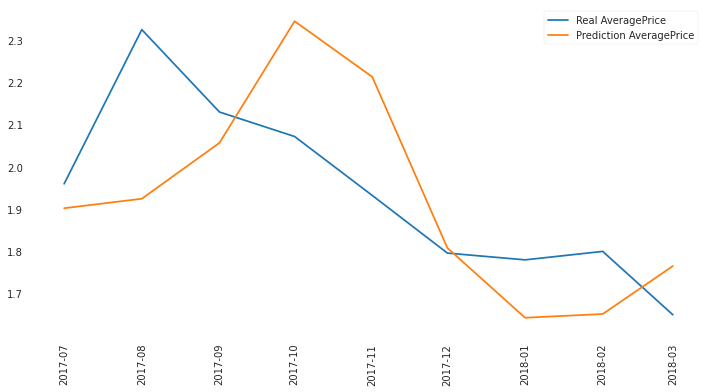

In [129]:
# Visulaize the result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='Real AveragePrice')
plt.plot(y_pred_value, label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: prediction và real value có sự chênh lệch chấp nhận được (~ 10% giá trị mean) nên mức dự đoán có thể chấp nhận được

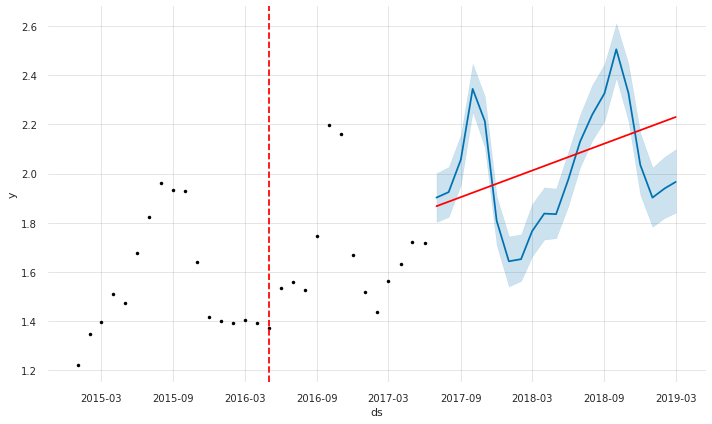

In [130]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),model,forecast)

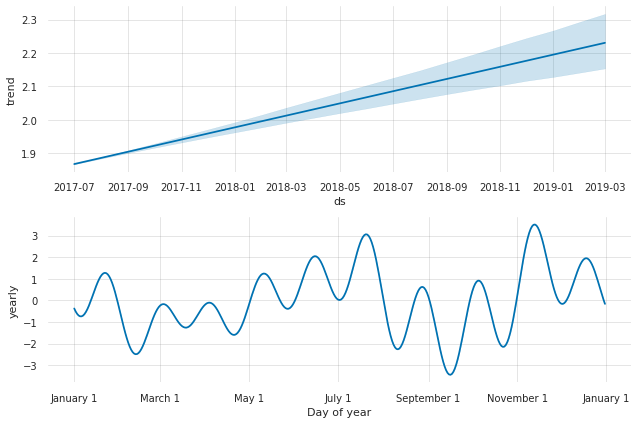

In [131]:
fig1 = model.plot_components(forecast)
fig1.show()

Nhận xét: xu hướng là tăng cho đến tháng 03/2019

#Dự đoán cho 12 tháng kế tiếp

In [132]:
forecast[['ds','yhat']].tail(12)

,ds,yhat
9,2018-04-01,1.837214
10,2018-05-01,1.834914
11,2018-06-01,1.975543
12,2018-07-01,2.130045
13,2018-08-01,2.240363
14,2018-09-01,2.326643
15,2018-10-01,2.506019
16,2018-11-01,2.327422
17,2018-12-01,2.035509
18,2019-01-01,1.902338


#Dự đoán cho 5 năm tiếp theo, chúng ta có thể mở rộng kinh doanh?

In [133]:
m = Prophet(yearly_seasonality=True, daily_seasonality=False,weekly_seasonality=False)
m.fit(df1) #fit df1 (dùng df1 để train) --> 39 tháng --> dự đoán tiếp 5  năm sau df1
future = m.make_future_dataframe(periods = 12*5,freq='M') # next 5 years

In [134]:
forecast = m.predict(future)

In [135]:
forecast.shape #39 tháng (train) + 60 tháng

(99, 16)

In [136]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          99 non-null     datetime64[ns]
 1   trend                       99 non-null     float64       
 2   yhat_lower                  99 non-null     float64       
 3   yhat_upper                  99 non-null     float64       
 4   trend_lower                 99 non-null     float64       
 5   trend_upper                 99 non-null     float64       
 6   additive_terms              99 non-null     float64       
 7   additive_terms_lower        99 non-null     float64       
 8   additive_terms_upper        99 non-null     float64       
 9   yearly                      99 non-null     float64       
 10  yearly_lower                99 non-null     float64       
 11  yearly_upper                99 non-null     float64       
 

In [137]:
forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
87,2022-03-31,2.506902,2.327426,2.697559,2.696619,2.574631,2.816376
88,2022-04-30,2.329192,2.142746,2.510317,2.711244,2.585249,2.834698
89,2022-05-31,2.532630,2.342131,2.738589,2.726356,2.597798,2.854697
90,2022-06-30,2.855965,2.659630,3.057676,2.740981,2.609487,2.873426
91,2022-07-31,3.295002,3.100572,3.498755,2.756094,2.619213,2.892038
92,2022-08-31,3.164768,2.970882,3.356108,2.771206,2.629956,2.909778
93,2022-09-30,2.911124,2.694613,3.109136,2.785831,2.640197,2.928340
94,2022-10-31,2.574144,2.366867,2.781508,2.800944,2.651421,2.947011
95,2022-11-30,2.736732,2.513511,2.937320,2.815569,2.661715,2.964688
96,2022-12-31,2.715594,2.495325,2.910643,2.830681,2.672235,2.982987


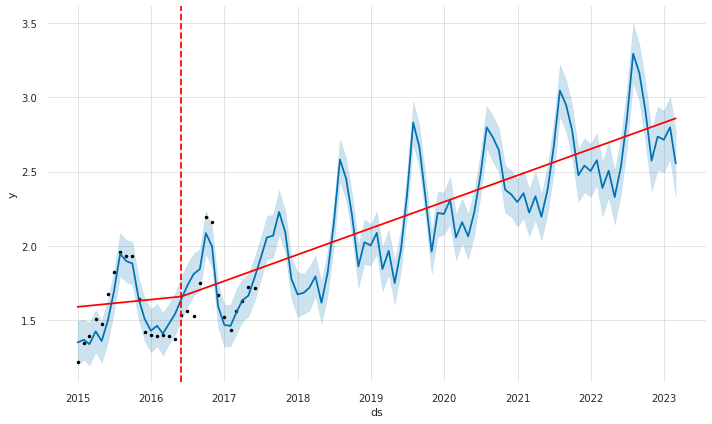

In [138]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(),m,forecast)

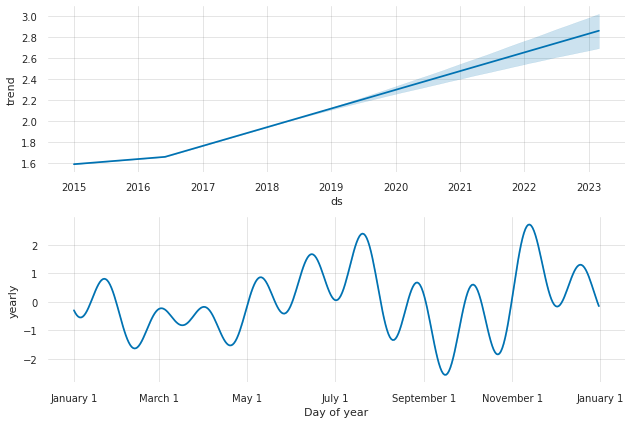

In [139]:
fig1 = m.plot_components(forecast)
fig1.show()

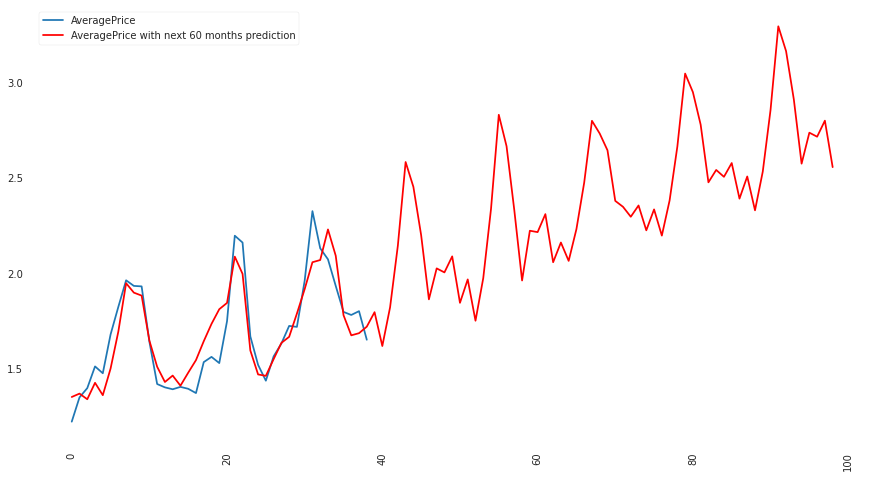

In [140]:
plt.figure(figsize=(15,8))
plt.plot(df1['y'],label='AveragePrice')
plt.plot(forecast['yhat'],label='AveragePrice with next 60 months prediction',color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Build model - ARIMA

In [142]:
from pmdarima import auto_arima 

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 11
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          169 non-null    datetime64[ns]
 1   AveragePrice  169 non-null    float64       
 2   type          169 non-null    object        
 3   region        169 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.6+ KB


In [153]:
df2 = df.resample('MS', on='Date').mean()

In [154]:
df2.head()

,AveragePrice
Date,
2015-01-01,1.2200
2015-02-01,1.3475
2015-03-01,1.3960
2015-04-01,1.5100
2015-05-01,1.4740


In [155]:
stepwise_model = auto_arima(df2, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=12,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-10.252, Time=3.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=0.610, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-11.187, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1.204, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-9.729, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-9.726, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-7.729, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-13.157, Time=0.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-11.726, Time=0.73 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-11.725, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-9.726, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-12.336, T

In [156]:
print(stepwise_model.aic())

-13.15651849363881


In [157]:
# Train & test: train  30 months, test 9 months
train = df2.iloc[:-9,:]
test = df2.iloc[-9:,:]

In [158]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [159]:
future_forecast = stepwise_model.predict(n_periods=len(test))
future_forecast

array([1.65994413, 1.50293681, 1.90354481, 2.67851458, 2.82638003,
       2.1384325 , 1.89338037, 1.75753715, 1.96828332])

In [160]:
future_forecast = pd.DataFrame(future_forecast,columns=['Prediction'],index=test.index)
future_forecast

,Prediction
Date,
2017-07-01,1.659944
2017-08-01,1.502937
2017-09-01,1.903545
2017-10-01,2.678515
2017-11-01,2.826380
2017-12-01,2.138432
2018-01-01,1.893380
2018-02-01,1.757537
2018-03-01,1.968283


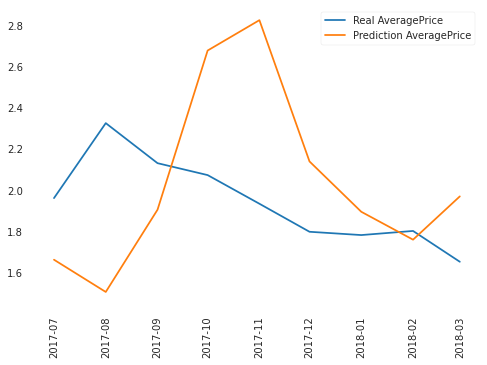

In [161]:
plt.plot(test,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

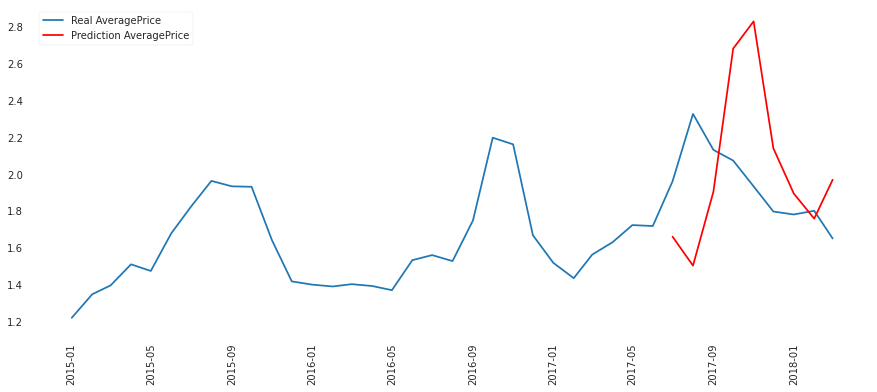

In [163]:
plt.figure(figsize=(15,6))
plt.plot(df2,label='Real AveragePrice')
plt.plot(future_forecast,label='Prediction AveragePrice',color='r')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Nhận xét: giá prediction và real có sự chênh lệch

#Evaluation

In [164]:
df2['AveragePrice'].mean()

1.6847820512820515

In [165]:
test['AveragePrice'].mean()

1.9383888888888887

In [166]:
mae = mean_absolute_error(test, future_forecast[0:len(test)])
mae

0.4072808773200545

In [167]:
mse = mean_squared_error(test, future_forecast[0:len(test)])
mse

0.24635636592379015

- Mean test = 1.938, mae & mse ~ 20% of mean test
- Mean all data = 1.685, mae & mse ~ 25% of mean data
- Chênh lệch lớn => không chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [168]:
future_forecast_12_month = stepwise_model.predict(n_periods=len(test)+12)
future_forecast_12_month

array([1.65994413, 1.50293681, 1.90354481, 2.67851458, 2.82638003,
       2.1384325 , 1.89338037, 1.75753715, 1.96828332, 2.091884  ,
       2.26763017, 2.14138032, 2.02225422, 1.77511858, 2.30646505,
       3.31775967, 3.5987216 , 2.76929356, 2.45507318, 2.28097782,
       2.55198421])

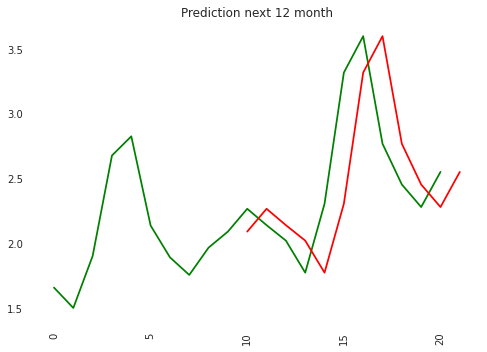

In [169]:
plt.plot(np.arange(21),future_forecast_12_month,color='g')
plt.plot(np.arange(10,22,1),future_forecast_12_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 month')
plt.show()

Dự báo cho 5 năm tiếp theo

In [170]:
future_forecast_60_month = stepwise_model.predict(n_periods=len(test)+60)
future_forecast_60_month

array([1.65994413, 1.50293681, 1.90354481, 2.67851458, 2.82638003,
       2.1384325 , 1.89338037, 1.75753715, 1.96828332, 2.091884  ,
       2.26763017, 2.14138032, 2.02225422, 1.77511858, 2.30646505,
       3.31775967, 3.5987216 , 2.76929356, 2.45507318, 2.28097782,
       2.55198421, 2.71619504, 2.95220143, 2.73818125, 2.57448572,
       2.26210801, 2.88809341, 4.0704588 , 4.44776658, 3.51592366,
       3.15163379, 2.94984849, 3.26447603, 3.45808371, 3.73771125,
       3.46015593, 3.26419748, 2.90459236, 3.59908496, 4.90528502,
       5.35233561, 4.34635664, 3.94582247, 3.72399298, 4.07019698,
       4.28508446, 4.59628847, 4.27274133, 4.05342842, 3.65963633,
       4.40371991, 5.79956138, 6.29709737, 5.23745281, 4.81068214,
       4.57434305, 4.94340462, 5.17369612, 5.50775769, 5.15091801,
       4.91469927, 4.49615992, 5.27614142, 6.73687248, 7.27095383,
       6.17246184, 5.72669909, 5.47985681, 5.86546451])

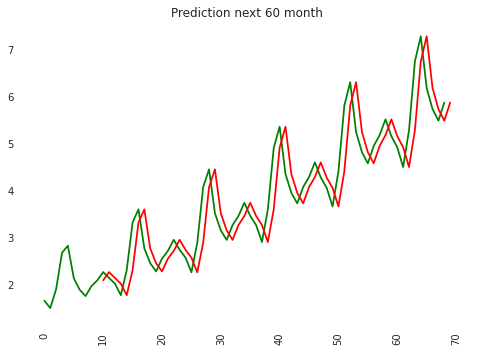

In [171]:
plt.plot(np.arange(69),future_forecast_60_month,color='g')
plt.plot(np.arange(10,70,1),future_forecast_60_month[len(test):],color='r')
plt.xticks(rotation='vertical')
plt.title('Prediction next 60 month')
plt.show()

<font color='blue'>- Từ biểu đồ cho thấy, xu hướng tăng trưởng của 5 năm tiếp theo có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này</font>

#Holt-Winters

In [172]:
model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12).fit()
pred = model.predict(start=test.index[0],end=test.index[-1])

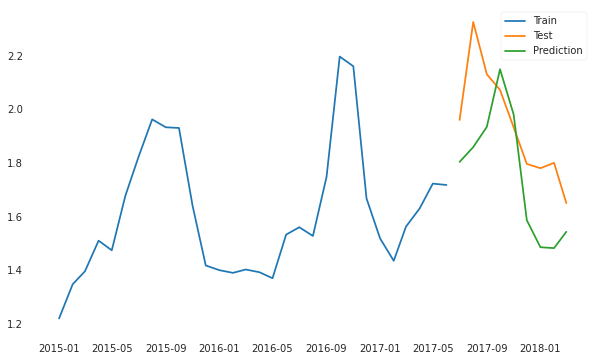

In [173]:
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.legend(loc='best')
plt.show()

#Evaluate

In [174]:
df2['AveragePrice'].mean()

1.6847820512820515

In [175]:
test['AveragePrice'].mean()

1.9383888888888887

In [176]:
y_test = test['AveragePrice'].values
y_pred = pred.values
mae = mean_absolute_error(y_test, y_pred)
mae

0.20803869559585905

In [177]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.24304654119674204

- Mean test = 1.983, mae & mse ~ 10% of mean test
- Mean all data = 1.685, mae & mse ~ 15% of mean data
- Chênh lệch nhỏ => chấp nhận được

Dự báo cho 12 tháng tiếp theo 

In [178]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2019,3,1)
pred_next_12_month = model.predict(start=start,end=end)
pred_next_12_month

2018-04-01    1.597340
2018-05-01    1.605905
2018-06-01    1.717500
2018-07-01    1.803541
2018-08-01    1.858656
2018-09-01    1.934121
2018-10-01    2.148825
2018-11-01    1.980484
2018-12-01    1.586308
2019-01-01    1.485520
2019-02-01    1.482189
2019-03-01    1.543126
Freq: MS, dtype: float64

In [179]:
x = pd.Series(pred_next_12_month)
type(x)

pandas.core.series.Series

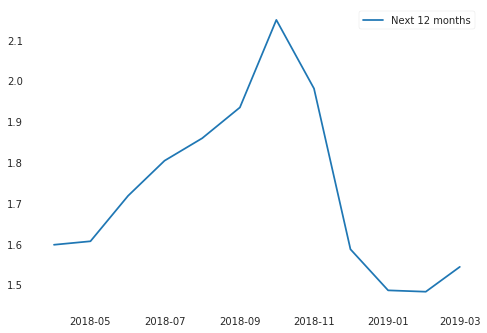

In [180]:
plt.plot(x.index,x,label='Next 12 months')
plt.legend(loc='best')

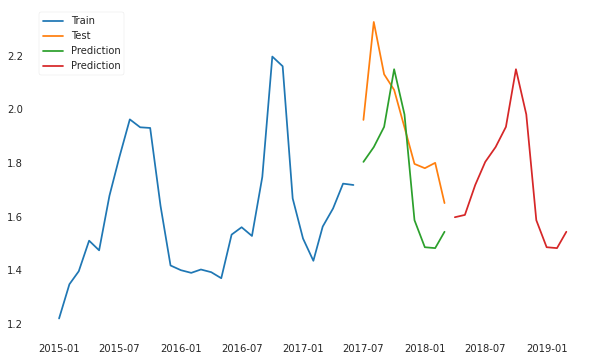

In [181]:
# Truc quan hoa 
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_12_month.index,pred_next_12_month,label='Prediction')
plt.legend(loc='best')
plt.show()

Dự báo cho 60 tháng tiếp theo 

In [182]:
import datetime
start = datetime.datetime(2018,4,1)
end = datetime.datetime(2023,3,1)
pred_next_60_month = model.predict(start=start,end=end)
pred_next_60_month[:10]

2018-04-01    1.597340
2018-05-01    1.605905
2018-06-01    1.717500
2018-07-01    1.803541
2018-08-01    1.858656
2018-09-01    1.934121
2018-10-01    2.148825
2018-11-01    1.980484
2018-12-01    1.586308
2019-01-01    1.485520
Freq: MS, dtype: float64

In [183]:
x = pd.Series(pred_next_60_month)
type(x)

pandas.core.series.Series

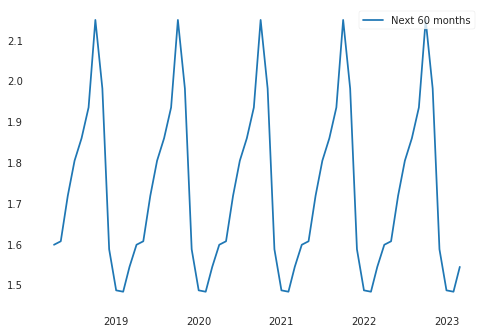

In [184]:
plt.plot(x.index,x,label='Next 60 months')
plt.legend(loc='best')

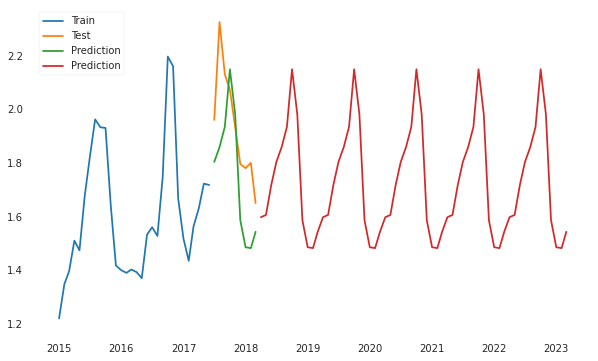

In [185]:
# Trực quan hóa
plt.figure(figsize=(10,6))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='Test')
plt.plot(pred.index,pred,label='Prediction')
plt.plot(pred_next_60_month.index,pred_next_60_month,label='Prediction')
plt.legend(loc='best')
plt.show()

<font color ='blue'> - Xu hướng tăng trưởng 5 năm tiếp theo biến động ổn định theo chu kỳ</font>

Tổng kết

###<font color='blue'>
- Qua phân tích các thuật toán Prophet, Arima, Holtwinters <br>
  <font color='blue'>
  + Prophet test data: mae & mse ~ 10%, all data: mae & mse ~ 15% => chênh lệch nhỏ chấp nhận được <br>
  + Arima test data: mae & mse ~ 20%, all data: mae & mse ~ 25% => chênh lệch lớn => không chọn thuật toán này <br>
  + Holtwinters test data: mae & mse ~ 10%, all data: mae & mse ~ 15% => chênh lệch nhỏ chấp nhận được</font>
- Dự báo xu hướng tăng trưởng từ 12 tháng đến 60 tháng tiếp theo của loại bơ organic tại vùng california, cả 3 thuật toán trên có mức độ tăng trưởng cao và biến động theo chu kỳ => có thể mở rộng sản xuất và kinh doanh tại khu vực này 
</font>